In this example we will perform an analysis for the app focusing on investigation why people remove app. Our negative target even in this case will be "app_remove".

In [220]:
from retentioneering import init_config
import pandas as pd

init_config(
    experiments_folder='mobile-app', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='not_screen4', # name of positive target event
    pos_target_definition={},
    negative_target_event='screen4', # name of positive target event
)

/Users/anatolyzaytsev/retentioneering-draft/retentioneering/core/utils.py:53: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringTrajectory'> under name 'trajectory' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringTrajectory(BaseTrajectory):
/Users/anatolyzaytsev/retentioneering-draft/retentioneering/core/utils.py:60: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringDataset'> under name 'retention' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringDataset(BaseDataset):


In [230]:
#data = pd.read_csv('examples/data/mobile-app-data.zip')
data = pd.read_csv('data.csv')
data = data.sort_values('event_timestamp')
# problems with timestamp order
#data.event_timestamp *= 1000
# adds positive event
data = data.retention.prepare()

Firstly, we need to filter and aggregate events.

To remove specific event simply click on the blue checkbox for selected event. To aggregare group of events to single parent event click on the smaller gray checkbox near parent event.

Now let's remove system events, screen_view, os events, user_engagement, from app we need just app_remove, 

In [225]:
data.retention.show_tree_selector()

After that you need to download created filter with using "Download Filter" link.

Now you can use this filter using next chunk.

Below you can upload filter file we created for the cases we illustrate later in this notebook

In [223]:
data = data.retention.use_tree_filter('filter_list.json')

Lets split data into sessions

In [226]:
data.retention.split_sessions(by_event='session_start')
#data['user_session'] = data.user_pseudo_id + data.session.astype(int).astype(str)
data['user_session'] = data.session.astype(int).astype(str)

# Analysis

## Step matrix

In [227]:
len(data.retention.get_positive_users())

911

In [228]:
len(data)

5833

In [229]:
f = data.retention.create_filter(index_col='user_session')
data.retention.get_step_matrix_difference(f, index_col='user_session');

KeyError: -1.0

From previous plot we can see that in sessions with removed app, users significantly slows down on onboarding (onb group) and on catalogue (prov group).

This is our first hypothesis about app problems.

## Clustering

In [216]:
data.retention.learn_tsne(index_col='user_session', plot_type='clusters');

ValueError: Found array with 1 sample(s) (shape=(1, 4)) while a minimum of 2 is required.

We can choose cluster from center and visualize it

We can see problems with catalogue for zero cluster: a lot of users move from app after first prov event.

In [217]:
data.retention.get_clusters(index_col='user_session');

ValueError: n_samples=1 should be >= n_clusters=8

In [203]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', thresh=0.06, width=800, height=800))

Selection process involves multiple steps were users edit their selected products and select different kind of options (node "param"). Users can do this without authorization. But after they add selected and customized products to cart they are asked to authorize.

In this cluster we can clearly see the problem with autorization: after authorization we need to return to catalogue (node "prov") and start selection and customization process all over again (node "prparam").

We can see from graph that there is no way to return after authorization to previous step in catalogue (no edge from "auth" to "prparam").

This is a problem in app: authorization brokes user trajectory, so user should return in the beginning.

We can see problems with detailed events via `dump_event_col` column.

In [197]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', cols=['dump_event_col', 'dump_event_col_shift'], thresh=0.08, width=800, height=800))

This graph can support our hypothesis about bad catalogue organization with `prov_click_category_other` event. We can see that users often remove app after this event, wich redirects users to web-page. It's clear example of not optimal app organization where web-page link cannibiling users from mobile app.

# Classifier

In [6]:
data.head()

,event_timestamp,event_name,user_pseudo_id,dump_event_col,session,user_session
0,2019-02-27 10:22:06.003000,app_remove,7be7da240172078b5d97b6b9942091f7,app_remove,0.0,7be7da240172078b5d97b6b9942091f70
1,2019-02-27 20:13:58.523000,onb,f3eb88ec2ef1e294a9014a1787b5678c,onb_auto_swipe,0.0,f3eb88ec2ef1e294a9014a1787b5678c0
2,2019-02-27 20:14:01.970003,prov,f3eb88ec2ef1e294a9014a1787b5678c,prov_scroll_catalog,0.0,f3eb88ec2ef1e294a9014a1787b5678c0
3,2019-02-27 20:14:03.857005,prov,f3eb88ec2ef1e294a9014a1787b5678c,prov_scroll_catalog,0.0,f3eb88ec2ef1e294a9014a1787b5678c0
4,2019-02-27 20:14:06.096006,prov,f3eb88ec2ef1e294a9014a1787b5678c,prov_scroll_catalog,0.0,f3eb88ec2ef1e294a9014a1787b5678c0


In [6]:
len(data_test)

382740

In [7]:
len(data_train)

1646505

In [51]:
list(range(len(val)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [129]:
thresh = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 40, 50, 60, 70, 80, 100]

val = [0.685662137497465,
       0.6713444997736533,
       0.6663466154584734,
       0.639990150209308,
       0.6432418568863811,
       0.6362916006339144,
       0.6415760869565217,
       0.6432386842845094,
       0.6469034341062518,
      0.6454268292682926,
      0.6461151305441963,
      0.6455611390284757,
      0.6532286835533357,
      0.6631459826480574,
      0.6585850556438791,
      0.6619187264348555,
      0.669750231267345,
       0.6763506625891947,
      0.6893474623535973,
      0.6979166666666666,
      0.7057034220532319,
      0.7029360967184801,
      0.7140077821011673,
       0.7176220806794055,
      0.72693266832917]

user_count_x = [0, 10, 20, 30, 50, 100, 200]
user_count = [4931, 3179, 2387, 1873, 1315, 802, 426]


user_avg_pred_x = [0, 2, 4, 6, 8]
user_avg_pred = [0.5615493814642061,
                0.5909745559289487, 
                0.5801487560913055, 
                0.5728260869565217,
                0.5776342823598474]

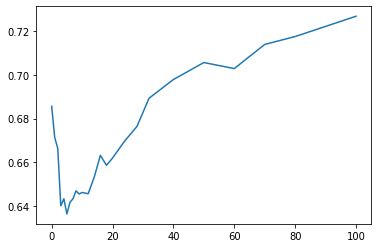

In [130]:
import matplotlib.pyplot as plt
plt.plot(thresh, val)
plt.show()

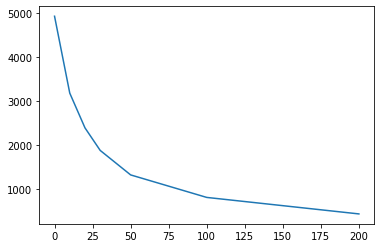

In [131]:
plt.plot(user_count_x, user_count)
plt.show()

In [117]:
import numpy as np

In [158]:
np.mean(target)

0.7215346534653465

In [157]:
len(target)

808

In [137]:
res = data_test.groupby(data_test.user_pseudo_id).agg({
    'event_timestamp':'count'
})

In [144]:
good_users_list=res[res['event_timestamp']>100].index.values.tolist()

In [147]:
len(good_users_list)

808

In [149]:
data_test['user_pseudo_id'] in good_users_list

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [150]:
'd702b2295eecdd236df48993a37bda18' in good_users_list

False

In [153]:
data_test_clean = data_test[data_test.apply(lambda x: x['user_pseudo_id'] in good_users_list, axis=1)]

In [154]:
data_test_clean.user_pseudo_id.nunique()

808

In [148]:
data_test[data_test['user_pseudo_id'] in good_users_list]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
data_test.groupby('')

In [152]:
data_test.user_pseudo_id.nunique()

5764

In [136]:
data_test.head()

,event_timestamp,event_name,user_pseudo_id,dump_event_col,session,user_session
61,2019-02-28 11:24:32.292000,ecom,d702b2295eecdd236df48993a37bda18,ecom_begin_checkout,0.0,d702b2295eecdd236df48993a37bda180
62,2019-02-28 11:28:59.694019,ecom,d702b2295eecdd236df48993a37bda18,ecom_begin_checkout,0.0,d702b2295eecdd236df48993a37bda180
70,2019-02-28 14:58:47.628003,prov,bc9fdf4523803849c763b1f086aa7041,prov_scroll_catalog,0.0,bc9fdf4523803849c763b1f086aa70410
71,2019-02-28 14:58:48.305004,prov,bc9fdf4523803849c763b1f086aa7041,prov_click_category,0.0,bc9fdf4523803849c763b1f086aa70410
72,2019-02-28 14:58:54.191007,prov,bc9fdf4523803849c763b1f086aa7041,prov_click_category_other,0.0,bc9fdf4523803849c763b1f086aa70410


In [155]:
#train test split
data_train , data_test = data.retention.index_based_split(index_col='user_pseudo_id')


res = data_test.groupby(data_test.user_pseudo_id).agg({
    'event_timestamp':'count'
})

good_users_list=res[res['event_timestamp']>100].index.values.tolist()

data_test_clean = data_test[data_test.apply(lambda x: x['user_pseudo_id'] in good_users_list, axis=1)]

In [160]:
target

array([ True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True, False, False,  True,
       False, False, False,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False,  True,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True,  True,

In [162]:
model.predict(features_test)

,False,True
00301a5e593a16d1850a3227544ac636,0.347672,0.652328
0052cd6480ade27af30e138831ac4669,0.308931,0.691069
00536fd2f1d3be802ad01901a1fcff39,0.319209,0.680791
006144ba49005a8c8def6428f5285a76,0.369653,0.630347
0073e7af489a3f3c6217f323c492eacb,0.281398,0.718602
00e32d7b8e3e9adf796bd93b43586dc9,0.344804,0.655196
0129fadfd14ad94cb37edaaa12122172,0.342927,0.657073
017ec7175785aea1b2340e9c5d154386,0.379287,0.620713
01a11f024fced1fb8a0f283750c4bad9,0.372211,0.627789
01a1dbd564fc8527b48578cfc31f9573,0.370761,0.629239


In [169]:
data_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287977 entries, 711 to 2029229
Data columns (total 6 columns):
event_timestamp    287977 non-null datetime64[ns]
event_name         287977 non-null object
user_pseudo_id     287977 non-null object
dump_event_col     287977 non-null object
session            287977 non-null float64
user_session       287977 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 15.4+ MB


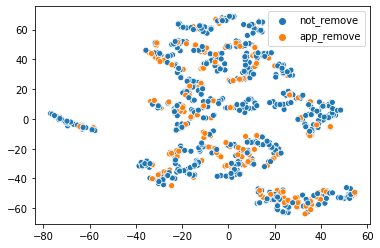

In [166]:
data_test_clean.retention.learn_tsne(perplexity=10, plot_type='targets', refit=True);

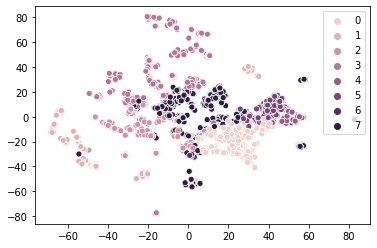

In [168]:
data_test_clean.retention.learn_tsne(index_col='user_session', plot_type='clusters', refit=True);

In [156]:
#create model on train
model = data_train.retention.create_model()

features_train = data_train.retention.extract_features(ngram_range=(1,2))

features_test = data_train.retention.extract_features_from_test(data_test_clean, train=features_train, ngram_range=(1,2), wo_last_k=0)

#add targets to test
target = features_test.index.isin(data_test_clean.retention.get_positive_users())

model.permutation_importance(features_test, target, thresh=1)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



            ROC-AUC: 0.6866857251762912
            PR-AUC: 0.8231690915326872
            Accuracy: 0.7462871287128713
            


/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/pandas-0.24.2-py3.7-macosx-10.9-x86_64.egg/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
/Users/anatolyzaytsev/retentioneering-draft/retentioneering/visualization/plot.py:291: RuntimeWarning: divide by zero encountered in log1p
  "weight": np.log1p(row.weight_norm) * 1.5,


In [19]:
#train test split
data_train , data_test = data.retention.index_based_split(index_col='user_pseudo_id')

#create model on train
model = data_train.retention.create_model()

#extract features for test
features_test = data_train.retention.extract_features_from_test(data_test, ngram_range=(1,2))

#add targets to test
target = features_test.index.isin(data_test.retention.get_positive_users())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/pandas-0.24.2-py3.7-macosx-10.9-x86_64.egg/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [23]:
model.permutation_importance(features_test, target, thresh=0.6)


            ROC-AUC: 0.7335440213090015
            PR-AUC: 0.7564212131421182
            Accuracy: 0.685662137497465
            


/Users/anatolyzaytsev/retentioneering-draft/retentioneering/visualization/plot.py:291: RuntimeWarning: divide by zero encountered in log1p
  "weight": np.log1p(row.weight_norm) * 1.5,


In [32]:
model = data.retention.create_model()

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
features = data.retention.extract_features(ngram_range=(1,2))
target = features.index.isin(data.retention.get_positive_users())

In [22]:
target

array([False,  True,  True, ..., False,  True,  True])

In [21]:
model.predict(features)

,False,True
000614144a842b8492bf67f177637996,0.521192,0.478808
000d184ae2d794809e8848d8c617a610,0.548006,0.451994
000dfdb9d14aa6b4dd8e7717ce1d0688,0.314649,0.685351
0010c136b28150e248cfd099ddee27b6,0.371151,0.628849
001552465edec679f8b991d269503019,0.265733,0.734267
00169b007e962a5c625f18e03ab6291c,0.278374,0.721626
0021435703a438ec38ae166b6523c56d,0.296398,0.703602
0021dead4ea07a0111dfe9928ac94e3c,0.354646,0.645354
00233f8d650663007d2fcc66b11f5f28,0.117068,0.882932
002601f0368ec2b1b1174fe04d912916,0.221483,0.778517


In [9]:
model.permutation_importance(features, target, thresh=0.)


            ROC-AUC: 0.7434215326281675
            PR-AUC: 0.7655270407257424
            Accuracy: 0.6946782127901777
            


/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/retentioneering-0.4.1-py3.7.egg/retentioneering/visualization/plot.py:291: RuntimeWarning: divide by zero encountered in log1p


# Predictor for purchase

In [170]:
from retentioneering import init_config
import pandas as pd


init_config(
    experiments_folder='mobile-app', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='dandd', # name of positive target event
    negative_target_event='not_purchase', # name of positive target event
    negative_target_definition={},
)

/Users/anatolyzaytsev/retentioneering-draft/retentioneering/core/utils.py:53: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringTrajectory'> under name 'trajectory' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringTrajectory(BaseTrajectory):
/Users/anatolyzaytsev/retentioneering-draft/retentioneering/core/utils.py:60: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringDataset'> under name 'retention' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringDataset(BaseDataset):


In [171]:
data = pd.read_csv('examples/data/mobile-app-data.zip')
data = data.sort_values('event_timestamp')
# problems with timestamp order
data.event_timestamp *= 1000
# adds positive event
data = data.retention.prepare()

In [172]:
data = data.retention.use_tree_filter('filter_list.json')

In [173]:
data.retention.split_sessions(by_event='session_start')
data['user_session'] = data.user_pseudo_id + data.session.astype(int).astype(str)

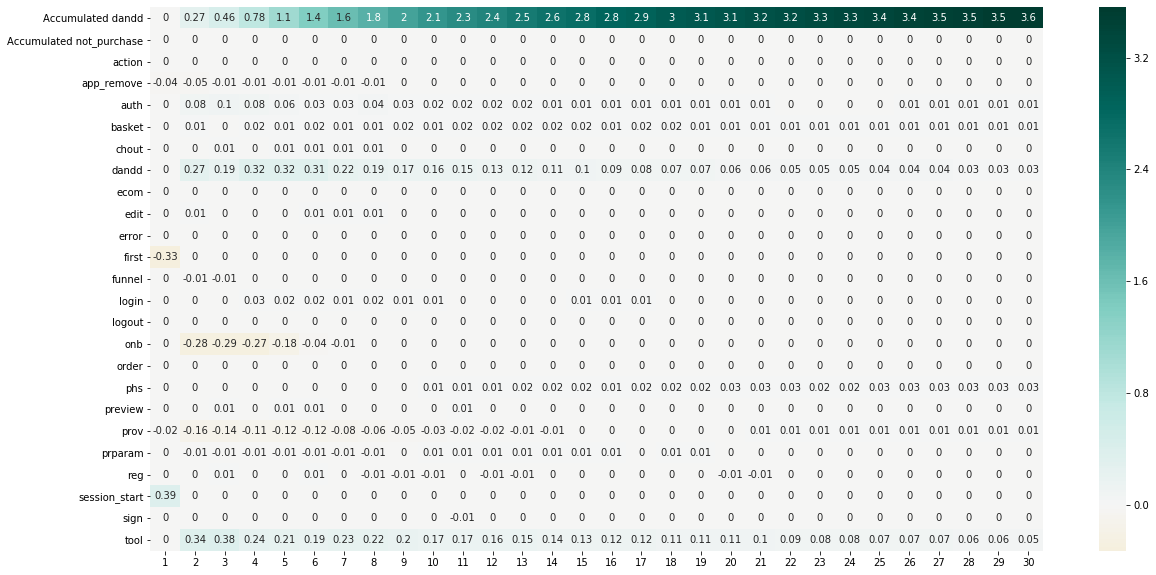

In [174]:
f = data.retention.create_filter(index_col='user_session')
data.retention.get_step_matrix_difference(f, index_col='user_session');

In [175]:
#train test split
data_train , data_test = data.retention.index_based_split(index_col='user_pseudo_id')


res = data_test.groupby(data_test.user_pseudo_id).agg({
    'event_timestamp':'count'
})

good_users_list=res[res['event_timestamp']>100].index.values.tolist()

data_test_clean = data_test[data_test.apply(lambda x: x['user_pseudo_id'] in good_users_list, axis=1)]

In [176]:
#create model on train
model = data_train.retention.create_model()

features_train = data_train.retention.extract_features(ngram_range=(1,2))

features_test = data_train.retention.extract_features_from_test(data_test_clean, train=features_train, ngram_range=(1,2), wo_last_k=0)

#add targets to test
target = features_test.index.isin(data_test_clean.retention.get_positive_users())

model.permutation_importance(features_test, target, thresh=1)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



            ROC-AUC: 0.7454789253844694
            PR-AUC: 0.753688140880333
            Accuracy: 0.7021791767554479
            


/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/pandas-0.24.2-py3.7-macosx-10.9-x86_64.egg/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


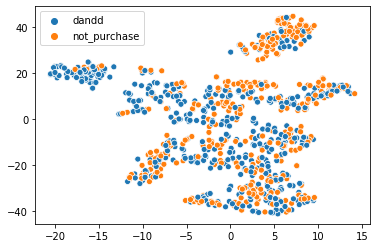

In [185]:
data_test_clean.retention.learn_tsne(perplexity=40, plot_type='targets', refit=True);